In [1]:
import pandas as pd
import numpy as np
import itertools
import re
import nltk
from functools import partial
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [2]:
comments = pd.read_csv('twitter_scrapped_final.csv',lineterminator='\n').drop(['Unnamed: 0'], axis=1).drop_duplicates(['text'])['text'].values
comments[0]

'Who you want to win in Pennsylvania? #Republicans #PennsylvaniaSenate #PrimaryDay'

In [3]:
Fetterman_list = ['johnfetterman', 'fetterman', 'fettermanforsenate', 'votefetterman', 'fettermanisthebetterman','fettermanforpa', 'giselefetterman','levifetterman','fettermanlt',
                'fetterwoman','fetterman2022','fettermania','fettermans', 'fettermandailymeme','fetter','votejohnfetterman','fettermen' ]
Oz_list = ['mehmetoz','mehmet', 'mehmetozthepuppymurderer', 'mehmetfromjersey', 'defundmehmetoz','snakeoilmehmetöz', 'mehmetozkillspuppies',
            'oz','voteoz','drozkillspuppies','droz','ooze','rejectoz','dogkilleroz','nooz','sendozhome','stopoz','ozisafraud','notooz', 'noozinpa', 'noonoz', 'voz',
            'votedroz', 'neveroz', 'ozfornj', 'saynotooz', 'ozzie', 'ozzy', 'realdoctorsagainstoz', 'ozforsenate', 'carpetbaggeroz', 'drozhitlercar', 'ozkillspuppies',
            'drozisafraud', 'ozisaquack', 'Dr. Oz', 'Dr Oz']

In [4]:
candidate_name_map = {"Fetterman": Fetterman_list, "Oz": Oz_list} 

# for word in Fetterman_list:
#     candidate_name_map[word] = "Fetterman"
# for word in Oz_list:
#     candidate_name_map[word] = "Oz"
# candidate_name_map

In [5]:
comment = comments[0]
print(comment)

Who you want to win in Pennsylvania? #Republicans #PennsylvaniaSenate #PrimaryDay


In [6]:
def get_lift_value(a_brand, b_brand, comments, candidate_name_map, attributes_flag=True):
    """
    returns the lift value for given two brands
    """
    n_a_b = 0
    n_a =0
    n_b =0
    i =0
    dummy = 0
    for comment in comments:
        n_a_tmp =0
        n_b_tmp =0
        if type(comment) == float:
            i = i+1
            continue
        else:
            if a_brand in comment.lower():
                n_a_tmp+=1
            if b_brand in comment.lower():
                n_b_tmp+=1
            word_set = [re.sub(r'[^\w]', ' ', word).strip().lower() for word in comment.split()]
            final_word_set = word_set.copy()
            final_word_set = [[re.sub(r'[^\w]', ' ', w).strip().lower()
                                                      for w in word.split()] for word in word_set if " " in word]
            final_word_set = list(set(list(itertools.chain.from_iterable(final_word_set))))
            final_word_set = list(set(word_set + final_word_set))
            if a_brand in candidate_name_map.keys():
                if set(final_word_set).intersection(set([a_brand] + candidate_name_map[a_brand])):
                    n_a_tmp+=1
            if set(final_word_set).intersection(set([a_brand])):
                n_a_tmp+=1
            if sum([1 for w in final_word_set if a_brand in w]):
                n_a_tmp+=1
            if b_brand in candidate_name_map.keys():
                if set(final_word_set).intersection(set([b_brand] + candidate_name_map[b_brand])):
                    n_b_tmp+=1
            if set(final_word_set).intersection(set([b_brand])):
                n_b_tmp+=1
            if sum([1 for w in final_word_set if b_brand in w]):
                n_b_tmp+=1                    
        if n_a_tmp>0:
            n_a = n_a + 1
        if n_b_tmp>0:
            n_b = n_b +1
        if n_a_tmp >0 and n_b_tmp > 0:
            n_a_b = n_a_b + 1
#     print(a_brand, b_brand, n_a, n_b, n_a_b)
    if n_a > 0 and n_b >0:
        return  (len(comments) - i) * (n_a_b / (n_a * n_b))
    else:
        return np.nan

In [7]:
# fixing the arguments comemnts and mis_brand_handle_t for function get_lift_value
get_lift_value_p = partial(get_lift_value, comments=comments, candidate_name_map = candidate_name_map)

In [8]:
%%time
lift_values = []
candidates_list = ["Fetterman", "Oz", "health", "abortion","gun", "security", "fraud", "crime"]
issue_list = ["Fetterman", "Oz", "health", "abortion","gun", "security", "fraud", "crime"]
# "Fetterman", "Oz", 
co_mentions_dict = {}
issues_lift_values = []
for cand in candidates_list:
    lift_value_tmp = []
    for iss in issue_list:
        lift= get_lift_value_p(cand, iss)
        lift_value_tmp.append(lift)
    issues_lift_values.append(lift_value_tmp)

CPU times: total: 58.6 s
Wall time: 1min 1s


In [9]:
issues_lift_values = pd.DataFrame(issues_lift_values, columns=issue_list, index=candidates_list)
issues_lift_values
# .to_csv('issue_lift_values.csv')

,Fetterman,Oz,health,abortion,gun,security,fraud,crime
Fetterman,3.260302,1.643015,1.113060,0.955166,1.337336,1.381850,1.819154,1.305613
Oz,1.643015,5.038539,1.232546,1.082499,0.702424,1.134506,2.756592,1.106864
health,1.113060,1.232546,73.803763,9.225470,1.187192,1.955067,1.871835,0.675549
abortion,0.955166,1.082499,9.225470,107.246094,1.725138,6.392151,0.777146,2.454144
gun,1.337336,0.702424,1.187192,1.725138,73.605898,0.487456,0.533376,2.358084
security,1.381850,1.134506,1.955067,6.392151,0.487456,181.821192,2.635090,2.080334
fraud,1.819154,2.756592,1.871835,0.777146,0.533376,2.635090,99.474638,0.682892
crime,1.305613,1.106864,0.675549,2.454144,2.358084,2.080334,0.682892,62.826087


In [10]:
for i in range(0, len(issues_lift_values)):
    issues_lift_values.iloc[i,i] = 1
issues_lift_values

,Fetterman,Oz,health,abortion,gun,security,fraud,crime
Fetterman,1.000000,1.643015,1.113060,0.955166,1.337336,1.381850,1.819154,1.305613
Oz,1.643015,1.000000,1.232546,1.082499,0.702424,1.134506,2.756592,1.106864
health,1.113060,1.232546,1.000000,9.225470,1.187192,1.955067,1.871835,0.675549
abortion,0.955166,1.082499,9.225470,1.000000,1.725138,6.392151,0.777146,2.454144
gun,1.337336,0.702424,1.187192,1.725138,1.000000,0.487456,0.533376,2.358084
security,1.381850,1.134506,1.955067,6.392151,0.487456,1.000000,2.635090,2.080334
fraud,1.819154,2.756592,1.871835,0.777146,0.533376,2.635090,1.000000,0.682892
crime,1.305613,1.106864,0.675549,2.454144,2.358084,2.080334,0.682892,1.000000


           Fetterman        Oz    health  abortion       gun  security  \
Fetterman   1.000000  0.608637  0.898424  1.046938  0.747756  0.723668   
Oz          0.608637  1.000000  0.811329  0.923789  1.423642  0.881441   
health      0.898424  0.811329  1.000000  0.108396  0.842324  0.511492   
abortion    1.046938  0.923789  0.108396  1.000000  0.579664  0.156442   
gun         0.747756  1.423642  0.842324  0.579664  1.000000  2.051466   
security    0.723668  0.881441  0.511492  0.156442  2.051466  1.000000   
fraud       0.549706  0.362767  0.534235  1.286760  1.874850  0.379494   
crime       0.765924  0.903453  1.480277  0.407474  0.424073  0.480692   

              fraud     crime  
Fetterman  0.549706  0.765924  
Oz         0.362767  0.903453  
health     0.534235  1.480277  
abortion   1.286760  0.407474  
gun        1.874850  0.424073  
security   0.379494  0.480692  
fraud      1.000000  1.464360  
crime      1.464360  1.000000  


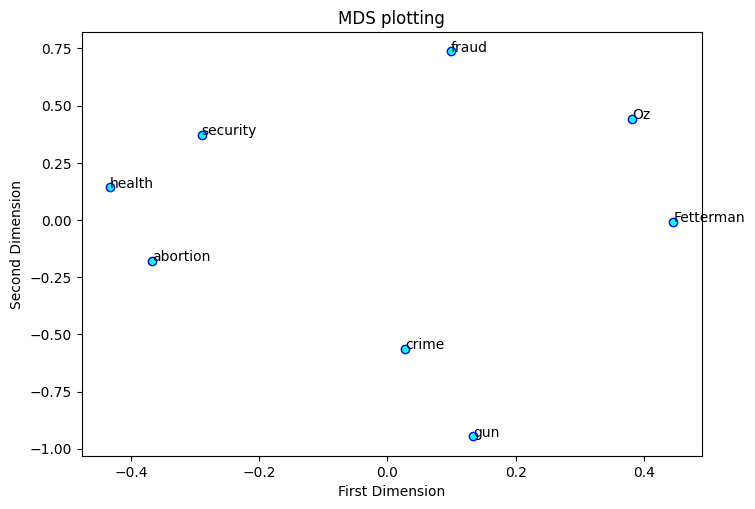

In [11]:
diff_mat = 1/issues_lift_values.iloc[:,:]
diff_mat
# for i in range(0, len(diff_mat.columns)):
#     diff_mat.iloc[i, i] =0
print(diff_mat)

mds_model = MDS(n_components = 2, random_state = 0, dissimilarity = 'precomputed')
mds_fit = mds_model.fit(diff_mat)  
mds_coords = mds_model.fit_transform(diff_mat)   

plt.rcParams["figure.figsize"] = (8,5.5)
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1],
    facecolors = 'cyan', edgecolors = 'blue')
labels = diff_mat.columns
for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
    plt.annotate(label, (x,y), xycoords = 'data')
plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('MDS plotting')    
plt.show()

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [13]:
def get_sentiment_score(candidate, issue, stop_words):
    relevant_comments = []
    for comment in comments:
        n_a_tmp = 0
        n_b_tmp = 0
        word_set = [re.sub(r'[^\w]', ' ', word).strip().lower() for word in comment.split()]
        final_word_set = word_set.copy()
        final_word_set = [[re.sub(r'[^\w]', ' ', w).strip().lower()
                                        for w in word.split()] for word in word_set if " " in word]
        final_word_set = list(set(list(itertools.chain.from_iterable(final_word_set))))
        final_word_set = list(set(word_set + final_word_set))
        if candidate in candidate_name_map.keys():
            if set(final_word_set).intersection(set([candidate] + candidate_name_map[candidate])):
                n_a_tmp+=1
        if set(final_word_set).intersection(set([candidate])):
            n_a_tmp+=1
        if sum([1 for w in final_word_set if candidate in w]):
            n_a_tmp+=1
        if set(final_word_set).intersection(set([issue])):
            n_b_tmp+=1
        if sum([1 for w in final_word_set if issue in w]):
            n_b_tmp+=1  
        if n_a_tmp >0 and n_b_tmp > 0:
            relevant_comments.append(comment)
            
            
    word_pair= []
    scores = []
    for line in relevant_comments:
        line_list = [re.sub(r'[^@\w]', ' ', word).strip().lower() for word in line.split()]
        new_line = []
        for word in line_list:
            if word in stop_words:
                continue
            new_line.append(word)
        try:
            idx = new_line.index(issue)
        except Exception as e:
            type(e)
            idx = [i for i in range(0, len(new_line)) if issue in new_line[i]][0]
        if idx + 2 < len(new_line) and idx - 2 >= 0:
            word_pair.append((new_line[idx-2] + " " + new_line[idx-1] + " " + new_line[idx] + " " +  new_line[idx+1] + " " +new_line[idx+2]))
        elif idx + 1 < len(new_line) and idx - 2 >= 0:
            word_pair.append((new_line[idx-2] + " " + new_line[idx-1] + " " + new_line[idx] + " " +  new_line[idx+1]))
        elif idx + 2 < len(new_line) and idx - 1 >= 0:
            word_pair.append((new_line[idx-1] + " " + new_line[idx] + " " + new_line[idx+1] + " " + new_line[idx+2]))           
        elif idx-2 >=0 and idx + 1  == len(new_line):
            word_pair.append((new_line[idx - 2] + " "+ new_line[idx - 1] + " " + new_line[idx] ))
        elif idx-1 >=0 and idx + 1  == len(new_line):
            word_pair.append((new_line[idx - 1] + " " + new_line[idx] ))
        elif idx == 0 and idx+2 < len(new_line):
            word_pair.append(( new_line[idx] + " " + new_line[idx + 1] + " " + new_line[idx + 2]))
        elif idx == 0 and idx+1 < len(new_line):
             word_pair.append(( new_line[idx] + " " + new_line[idx + 1]))
            

    new_words = {'health' : 0,
                 'abortion' : 0,
                 'gun' : 0, 
                 'security' : 0,
                 'fraud': 0,
                 'crime' : 0, 
                 'puppies' : 0,
                 'dog':0,
                 'black':0
        
    }
    analyzer = SentimentIntensityAnalyzer()
    analyzer.lexicon.update(new_words)
    for sentence in word_pair:
        score =  analyzer.polarity_scores(sentence)
        scores.append(score['compound'])
    return sum(scores) / len(scores)

In [14]:
%%time
sentiment_dict = {}
issues = ['health', 'abortion', 'gun', 'security', 'fraud', 'crime']
candidates = ['Fetterman', 'Oz']
for candidate in candidates:
    for issue in issues:
        if issues_lift_values.loc[candidate, issue] > 1:
            sentiment_dict[issue+ '_' + candidate] = get_sentiment_score(candidate, issue, stop_words)

CPU times: total: 9.81 s
Wall time: 10.4 s


In [15]:
candidate = 'Fetterman'
f_keys = [key for key in sentiment_dict.keys() if candidate in key]
fetterman_df = pd.DataFrame(columns=['issue', 'lift', 'sentiment'])
for key in f_keys:
    values = [key.split('_')[0], issues_lift_values.loc[candidate,key.split('_')[0]], sentiment_dict[key]]
    fetterman_df = pd.concat([fetterman_df, pd.DataFrame([values], columns=['issue', 'lift', 'sentiment'])], axis=0)
fetterman_df

,issue,lift,sentiment
0,health,1.113060,0.097012
0,gun,1.337336,-0.005576
0,security,1.381850,-0.054848
0,fraud,1.819154,-0.053897
0,crime,1.305613,-0.080703


In [16]:
candidate = 'Oz'
f_keys = [key for key in sentiment_dict.keys() if candidate in key]
oz_df = pd.DataFrame(columns=['issue', 'lift', 'sentiment'])
for key in f_keys:
    values = [key.split('_')[0], issues_lift_values.loc[candidate,key.split('_')[0]], sentiment_dict[key]]
    oz_df = pd.concat([oz_df, pd.DataFrame([values], columns=['issue', 'lift', 'sentiment'])], axis=0)
oz_df

,issue,lift,sentiment
0,health,1.232546,0.060585
0,abortion,1.082499,-0.182493
0,security,1.134506,-0.003574
0,fraud,2.756592,-0.090215
0,crime,1.106864,-0.049878
